# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from PIL import Image
from numpy import asarray
from os.path import dirname, join as pjoin
import scipy.io as sio
import json
import time
import cv2
import matplotlib.cm as cm
from tensorflow.keras.applications.vgg16 import preprocess_input

## Mall Dataset

Mall dataset was captured by a public surveillance camera in a shopping mall, which contains more challenging lighting conditions and more severe perspective distortion than the UCSD dataset. 
The dataset is composed by RGB images of frames in a video (as inputs) and the object counting on every frame, this is the number of pedestrians (object) in the image. The images are 480x640 pixels at 3 channels of the same spot recorded by a webcam in a mall but it has different number of person on every frame, is a problem of crowd counting.

It is taken from https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html

### Images

In [2]:
def load_dataset_jpg(path_data):

        
    lista_images=[]

    # Append images to a list
    for item in os.listdir(path_data):
        if os.path.isfile(path_data+item) & (item.endswith(".jpg")):
            im = Image.open(path_data+item).convert("RGB")
            im = np.array(im)
            lista_images.append(np.array(im))
    
            
    return lista_images

In [25]:
images_Mall = load_dataset_jpg('frames/')

In [26]:
# Convert and save the list of images in '.npy' format
np.save("images_Mall.npy",images_Mall)

In [5]:
images_MALL = np.load("images_Mall.npy")
images_MALL.shape

(2000, 480, 640, 3)

### Ground truth and labels

In [10]:
# ground truth

gt_MALL = sio.loadmat("mall_gt.mat")

In [5]:
labels_MALL = [len(gt_MALL["frame"][0,i][0,0][0]) for i in range(2000)]

In [6]:
# Convert and save the list of images in '.npy' format
np.save("labels_MALL.npy",labels_MALL)

In [6]:
labels_MALL = np.load("labels_MALL.npy")
labels_MALL.shape

(2000,)

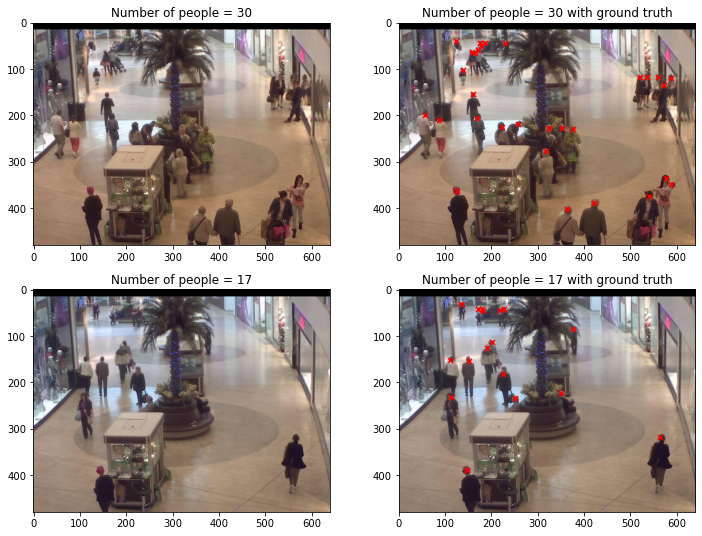

In [12]:
# lest's display 2 images with the corresponding labels and ground truth

f, ax = plt.subplots(2,2, figsize = (12, 9))

ax[0,0].imshow(images_MALL[1])
ax[0,1].imshow(images_MALL[1])
ax[1,0].imshow(images_MALL[50])
ax[1,1].imshow(images_MALL[50])

# adding ground truth
for x,y in gt_MALL["frame"][0,1][0,0][0]:
    ax[0,1].scatter(round(x),round(y), s = 25, marker = "x", color = "r")
for x,y in gt_MALL["frame"][0,50][0,0][0]:
    ax[1,1].scatter(round(x),round(y), s = 25, marker = "x", color = "r")

# titles
ax[0,0].set_title(f"Number of people = {labels_MALL[1]}")
ax[0,1].set_title(f"Number of people = {labels_MALL[1]} with ground truth")
ax[1,0].set_title(f"Number of people = {labels_MALL[50]}")
_=ax[1,1].set_title(f"Number of people = {labels_MALL[50]} with ground truth")

## Density function

In [16]:
def density_MALL(img_number):
    
    '''
    Input:
    - img_number: number of the image
    '''  
          
    output = np.zeros(images_MALL[img_number].shape[:-1])
    x_full = gt_MALL["frame"][0, img_number][0, 0][0][:,0] 
    y_full = gt_MALL["frame"][0, img_number][0, 0][0][:,1]

    for x, y in zip(x_full, y_full):
        density_img = np.zeros(images_MALL[img_number].shape[:-1])
        try:
            density_img[round(y),round(x)] = 1
        except:
            pass

        sigma = 3 
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size,kernel_size), sigma)
        output += density_img    
    
    return cv2.GaussianBlur(output, (11,11), sigma)

Time: 0.07638192176818848


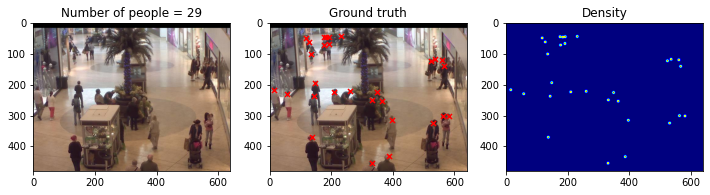

In [9]:
# density map on first image of MALL dataset

start = time.time()
ds = density_MALL(0)
print(f"Time: {time.time() - start}")

plt.figure(figsize=(12, 9))

#image with label
plt.subplot(1, 3, 1)
plt.imshow(images_MALL[0])
plt.title(f"Number of people = {labels_MALL[0]}")

# image with ground truth
plt.subplot(1, 3, 2)
plt.imshow(images_MALL[0])
for x,y in gt_MALL["frame"][0, 0][0, 0][0]:
    plt.scatter(round(x),round(y), s = 25, marker = "x", color = "r")
plt.title("Ground truth")

# image with density map
plt.subplot(1, 3, 3)
plt.imshow(ds , cmap = cm.jet)
_ = plt.title("Density")

## Density images

In [9]:
dens_images_MALL = []

for img in range(images_MALL.shape[0]):
    dens_images_MALL.append(density_MALL(img))


In [10]:
# Convert and save the list of images in '.npy' format
np.save("density_MALL.npy",dens_images_MALL)

In [19]:
density_MALL = np.load("density_MALL.npy")
density_MALL.shape

(2000, 480, 640)

## Train and test

In [6]:
# train
X_train = images_MALL[:800]
Dens_train = density_MALL[:800]

# test
X_test = images_MALL[800:]
Dens_test = density_MALL[800:]

In [7]:
np.save("train_MALL.npy",X_train)
np.save("dens_train_MALL.npy",Dens_train)

np.save("test_MALL.npy",X_test)
np.save("dens_test_MALL.npy",Dens_test)

In [2]:
train_MALL = np.load("train_MALL.npy")
train_MALL.shape

(800, 480, 640, 3)

In [3]:
density_train_MALL = np.load("dens_train_MALL.npy")
density_train_MALL.shape

(800, 480, 640)

In [8]:
test_MALL = np.load("test_MALL.npy")
test_MALL.shape

(1200, 480, 640, 3)

In [22]:
density_test_MALL = np.load("dens_test_MALL.npy")
density_test_MALL.shape

(1200, 480, 640)

## Preprocessing for VGG16

In [4]:
# Preprocess data for vgg16

prepro_list = []

for img in train_MALL:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train = np.array(prepro_list)
prepro_train.shape

(800, 480, 640, 3)

In [5]:
np.save("prepro_train_MALL.npy",prepro_train)

In [2]:
prepro_train_MALL = np.load("prepro_train_MALL.npy")
prepro_train_MALL.shape

(800, 480, 640, 3)

In [4]:
# Preprocess data for vgg16

prepro_list = []

for img in test_MALL:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test = np.array(prepro_list)
prepro_test.shape

(800, 480, 640, 3)

In [5]:
np.save("prepro_test_MALL.npy",prepro_train)

In [14]:
prepro_test_MALL = np.load("prepro_test_MALL.npy")
prepro_test_MALL.shape

(1200, 480, 640, 3)

## Datasets divided

In [4]:
half_prepro_train_MALL = prepro_train_MALL[:360]
half_dens_train_MALL = density_train_MALL[:360]

np.save("half_prepro_train_MALL.npy",half_prepro_train_MALL)
np.save("half_dens_train_MALL.npy",half_dens_train_MALL)

In [5]:
half2_prepro_train_MALL = prepro_train_MALL[440:]
half2_dens_train_MALL = density_train_MALL[440:]

np.save("half2_prepro_train_MALL.npy",half2_prepro_train_MALL)
np.save("half2_dens_train_MALL.npy",half2_dens_train_MALL)

### Validation data

In [7]:
half_prepro_val_MALL = prepro_train_MALL[360:440]
half_dens_val_MALL = density_train_MALL[360:440]

np.save("half_prepro_val_MALL.npy",half_prepro_val_MALL)
np.save("half_dens_val_MALL.npy",half_dens_val_MALL)